# How to decorrelate vectors from sensitive features

I.e., how to do debiasing.

In [1]:
# import everything required
import numpy as np
import pandas as pd
import keras as ks
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LogisticRegression

# for reproducibility
np.random.seed(123)

/anaconda/envs/mlp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load data
PATH="datasets/german_credit.csv"
raw_data = pd.read_csv(PATH, index_col=False)
df = pd.DataFrame(raw_data)
df

,ns1,ns2,ns3,ns4,ns5,ns6,ns7,ns8,s9,ns10,...,ns12,s13,ns14,ns15,ns16,ns17,ns18,ns19,ns20,y
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [3]:
# one-hot encode categorical variables
categoricals = ["ns1", "ns3", "ns4", "ns6", "ns7", "s9", "ns10", "ns12", "ns14", "ns15", "ns17", "ns19", "ns20"]
for a in categoricals:
    one_hot = pd.get_dummies(df[a])
    df = df.join(one_hot)
    df = df.drop(a, axis=1)
# create labels, drop labels from main database
y = df["y"]
df = df.drop("y", axis=1)

In [4]:
# normalise database
df = (df - df.mean()) / df.var()
y = y - 1

In [5]:
# train-test split
X_train = df[0:800]
X_val = df[800:900]
X_test = df[900:1000]
y_train = y[0:800]
y_val = y[800:900]
y_test = y[900:1000]

In [6]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

# In the next section, I investigate neural networks and logistic regression

## Use logistic regression

I computed elsewhere that the feature with the biggest mutual information with the applicant's sex (`s9`) is feature `ns5`, i.e. the applicant's credit score. Annoyingly, this is also the feature that has highest mutual information with the target `y`. The goal of this section is to figure out whether this is bad news or not, by first computing the accuracy of a logistic regression with the credit score information untouched, and computing the accuracy of a logistic regression with the credit score information fiddled with.

### Untouched logistic regression:

In [24]:
def fit_logistic_regression(X, y):
    model = LogisticRegression()
    model = model.fit(X, y)
    
    return model
    #return model.coef_, model.intercept_, model.Score(X, y)

model = fit_logistic_regression(X_train, y_train)

print(model.score(X_val, y_val))

0.72


### Logistic regression with fiddled `ns5`

In [27]:
X_train_fiddled = X_train.copy()
X_train_fiddled['ns5'] += np.random.rand(1)*10000


model = fit_logistic_regression(X_train, y_train)

print(model.score(X_val, y_val))

0.72


In [28]:
X_train_fiddled

,ns2,ns5,ns8,ns11,s13,ns16,ns18,A11,A12,A13,...,A152,A153,A171,A172,A173,A174,A191,A192,A201,A202
0,-0.102486,9758.305151,0.820601,0.948125,0.243073,1.777127,-1.182248,3.645985,-1.366621,-1.066169,...,1.401122,-1.119955,-1.021472,-1.24875,1.585714,-1.172535,-2.472772,2.472772,1.037383,-1.037383
1,0.186343,9758.305751,-0.777453,-0.693650,-0.104682,-1.219714,-1.182248,-1.376033,3.713755,-1.066169,...,1.401122,-1.119955,-1.021472,-1.24875,1.585714,-1.172535,1.676175,-1.676175,1.037383,-1.037383
2,-0.061225,9758.305268,-0.777453,0.127238,0.103971,-1.219714,6.445161,-1.376033,-1.366621,-1.066169,...,1.401122,-1.119955,-1.021472,4.99500,-2.700000,-1.172535,1.676175,-1.676175,1.037383,-1.037383
3,0.145081,9758.305994,-0.777453,0.948125,0.073060,-1.219714,6.445161,3.645985,-1.366621,-1.066169,...,-3.480836,9.250000,-1.021472,-1.24875,1.585714,-1.172535,1.676175,-1.676175,1.037383,-1.037383
4,0.021298,9758.305616,0.021574,0.948125,0.134883,1.777127,6.445161,3.645985,-1.366621,-1.066169,...,-3.480836,9.250000,-1.021472,-1.24875,1.585714,-1.172535,1.676175,-1.676175,1.037383,-1.037383
5,0.103820,9758.306141,-0.777453,0.948125,-0.004219,-1.219714,6.445161,-1.376033,-1.366621,-1.066169,...,-3.480836,9.250000,-1.021472,4.99500,-2.700000,-1.172535,-2.472772,2.472772,1.037383,-1.037383
6,0.021298,9758.305360,0.021574,0.948125,0.134883,-1.219714,-1.182248,-1.376033,-1.366621,-1.066169,...,1.401122,-1.119955,-1.021472,-1.24875,1.585714,-1.172535,1.676175,-1.676175,1.037383,-1.037383
7,0.103820,9758.305877,-0.777453,-0.693650,-0.004219,-1.219714,-1.182248,-1.376033,3.713755,-1.066169,...,-3.480836,-1.119955,-1.021472,-1.24875,-2.700000,6.750000,-2.472772,2.472772,1.037383,-1.037383
8,-0.061225,9758.305388,-0.777453,0.948125,0.196706,-1.219714,-1.182248,-1.376033,-1.366621,-1.066169,...,1.401122,-1.119955,-1.021472,4.99500,-2.700000,-1.172535,1.676175,-1.676175,1.037383,-1.037383
9,0.062559,9758.305661,0.820601,-0.693650,-0.058315,1.777127,-1.182248,-1.376033,3.713755,-1.066169,...,1.401122,-1.119955,-1.021472,-1.24875,-2.700000,6.750000,1.676175,-1.676175,1.037383,-1.037383


## Use neural networks

In [10]:
# from keras.models import Sequential
# from keras.layers import Dense

# create model
model = ks.Sequential()
model.add(ks.layers.Dense(200, activation='relu', input_shape=(61,)))
model.add(ks.layers.Dense(100, activation='relu'))
model.add(ks.layers.Dense(50, activation='relu'))
model.add(ks.layers.Dense(1, activation='sigmoid'))
# early stopping
es = ks.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1, mode='auto')
# compile model
model.compile(loss='mean_squared_error', optimizer='adam')
# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1, 
          callbacks=[es], validation_split=0.5, validation_data=(X_val, y_val))

Train on 800 samples, validate on 100 samples
Epoch 1/100
800/800 [==============================] - 1s 1ms/step - loss: 0.2242 - val_loss: 0.1696
Epoch 2/100
800/800 [==============================] - 0s 84us/step - loss: 0.1552 - val_loss: 0.1838
Epoch 3/100
800/800 [==============================] - 0s 78us/step - loss: 0.1249 - val_loss: 0.1664
Epoch 4/100
800/800 [==============================] - 0s 254us/step - loss: 0.1007 - val_loss: 0.1603
Epoch 5/100
800/800 [==============================] - 0s 76us/step - loss: 0.0842 - val_loss: 0.1692
Epoch 6/100
800/800 [==============================] - 0s 76us/step - loss: 0.0693 - val_loss: 0.1769
Epoch 7/100
800/800 [==============================] - 0s 69us/step - loss: 0.0569 - val_loss: 0.1694
Epoch 8/100
800/800 [==============================] - 0s 76us/step - loss: 0.0463 - val_loss: 0.1787
Epoch 9/100
800/800 [==============================] - 0s 66us/step - loss: 0.0372 - val_loss: 0.1816
Epoch 00009: early stopping


800/800 [==============================] - 0s 59us/step
0.18161741375923157 0.029052670449018478
dict_keys(['val_loss', 'loss'])


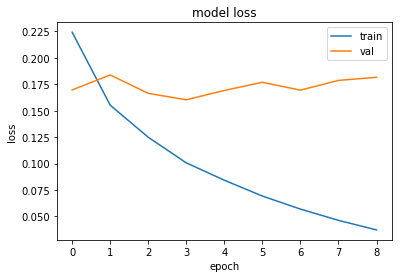

In [11]:
# evaluate the model
val_loss = model.evaluate(X_val, y_val)
train_loss = model.evaluate(X_train, y_train)
print(val_loss, train_loss)
# history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# To do 

DONE: implement early stopping 
look into GANs to augment data 
get feedback for IPP 
DONE: do bootstrapping
read a paper real quick


In [12]:
print(model.predict(X_train[500:505]))
print(y_train[500:505])

[[0.761457  ]
 [0.19942893]
 [0.09418482]
 [0.8612497 ]
 [0.8763769 ]]
500    1.0
501    0.0
502    0.0
503    1.0
504    1.0
Name: y, dtype: float32


In [13]:
base_scores = np.abs(model.predict(X_val) - y_val.values.reshape((100,1)))

In [14]:
def permute(x):
    n = len(x)
    score = 0
    for i in range(n):
        index = np.random.randint(n)
        score += x[index]
    return score

def bootstrap(x, number_of_times):
    histogram = np.zeros((number_of_times, 1))
    for i in range(number_of_times):
        histogram[i] = permute(x)
    return histogram

In [15]:
distribution = bootstrap(base_scores, 10000)

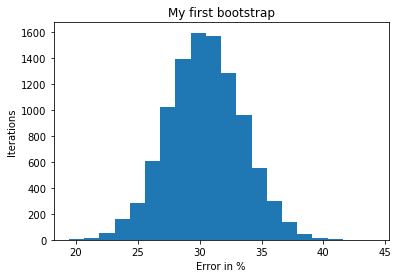

In [16]:
plt.hist(distribution, 20)
plt.title("My first bootstrap")
plt.ylabel("Iterations")
plt.xlabel("Error in %")
plt.show()

In [17]:
average = np.average(distribution)
var = np.var(distribution)
print("Average error is", average, "with variance", var)

Average error is 30.43918024158478 with variance 9.054299772817169


## Finding mutual information 

In [18]:
from sklearn import feature_selection

In [19]:
feature_selection.mutual_info_()

TypeError: 'module' object is not callable